## General Analysis of Suicide Rates
https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016

- **country**:
country of suicide
- **year**:
year of suicide
- **sex**:
gender
- **age**:
age range of the person who committed suicide
- **suicides_no**: 
the raw number of reported suicides
- **population**:
country population
- **suicides_100k**:
suicides_no * 100k / population
- **gdp_for_year**:
total monetary or market value of all final goods and services produced in a country in a given year
- **gdp_per_capita**:
the ratio of real GDP to the average population of a specific year
- **generation**:
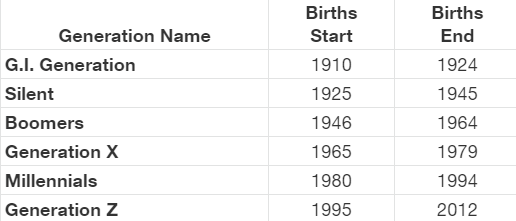

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# from pylab import rcParams
# rcParams['figure.figsize'] = (25,10)

In [ ]:
df_suicide=pd.read_csv('../input/suicide-rates-overview-1985-to-2016/master.csv')
df_suicide.head()

If we add the regions and continents of the countries to our dataset, we will have a more detailed analysis opportunity. For this reason, we will use an auxiliary dataset from kaggle that contains country continent information.

In [ ]:
# dataset resource : https://www.kaggle.com/andradaolteanu/country-mapping-iso-continent-region

df_continent=pd.read_csv('../input/continents/continents2.csv')
df_continent

### Find Mismatches

Before merging the two datasets, we need to detect and fix any mismatches in the country names. Let's write a function for this.

In [ ]:
def mismatch (series_1, series_2, only_out=True):
    out_num = 0
    for i in series_1.unique():
        if i in series_2.unique():
#         if any(series_2.unique() == i):  # alternative
            if not only_out:
                print("in :",i)
        else:
            print("out :",i)
            out_num += 1
    print(f"{out_num} mismatch(es) between those dataframes".upper())
    
mismatch(df_suicide.country, df_continent.name, True)

In [ ]:
df_continent.loc[df_continent.name.str.contains("Bosnia"),'name']='Bosnia and Herzegovina'
df_continent.loc[df_continent.name.str.contains("Maca"),'name']='Macau'
df_continent.loc[df_continent.name.str.contains("Korea, Republic of"),'name']='Republic of Korea'
df_continent.loc[df_continent.name.str.contains("Russia"),'name']='Russian Federation'
df_continent.loc[df_continent.name.str.contains("Vincent"),'name']='Saint Vincent and Grenadines'
mismatch(df_suicide.country, df_continent.name, True)

We merge two datasets over the country names column.

In [ ]:
df = df_suicide.merge(df_continent[['name','region','sub-region','alpha-3']], left_on='country', right_on='name')
df

Let's do Descriptive Analysis

In [ ]:
df.describe()

In [ ]:
def summary(df, pred=None):
    obs = df.shape[0]
    Types = df.dtypes
    Counts = df.apply(lambda x: x.count())
    Min = df.min()
    Max = df.max()
    Uniques = df.apply(lambda x: x.unique().shape[0])
    Nulls = df.apply(lambda x: x.isnull().sum())
    print('Data shape:', df.shape)

    if pred is None:
        cols = ['Types', 'Counts', 'Uniques', 'Nulls', 'Min', 'Max']
        str = pd.concat([Types, Counts, Uniques, Nulls, Min, Max], axis = 1, sort=True)

    str.columns = cols
    print('___________________________\nData Types:')
    print(str.Types.value_counts())
    print('___________________________')
    display(str.sort_values(by='Nulls', ascending=False))

summary(df)

In [ ]:
df[" gdp_for_year ($) "] = df[" gdp_for_year ($) "].apply(lambda x: int(x.replace(',','')))

**Rename Columns**

Let's edit the features names

In [ ]:
df.columns

In [ ]:
df = df.rename(columns={'suicides/100k pop':'suicides_100k',
                       'country-year':'country_year',
                       'HDI for year':'hdi_for_year',
                       ' gdp_for_year ($) ':'gdp_for_year',
                       'gdp_per_capita ($)':'gdp_per_capita',
                       'sub-region':'sub_region',
                       'alpha-3':'alpha_3'})
df.columns

**Check unique values**

Let's check if there are any anomalies by checking the Unique values of the features.

In [ ]:
print('Unique Values of Features:\n')
for i in ['country','region','sub_region','age','generation','sex','year']:
    print(f'{i}:\n{sorted(df[i].unique())}\n')

When sorted, let's change '5-14 years' to '05-14 years' so that it can sort in the correct hierarchy

In [ ]:
df.age = df.age.replace({'5-14 years':'05-14 years'})

### Handling Missing Values

Let's check Missing Values. If the missing value is small, let's make 'filling' and if it is a large number, 'dropping'

In [ ]:
def null_values(df):
    """a function to show null values with percentage"""
    nv=pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    return nv[nv.Missing_Records>0].sort_values('Missing_Records', ascending=False)

In [ ]:
# check number of null values and visualize it 
plt.figure(figsize=(15,3))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
null_values(df)

In [ ]:
df.drop('hdi_for_year',axis=1,inplace=True)
df.isnull().any().sum()

### Dropping Unnecessary Variables

In [ ]:
df[['country','year','country_year','name']]

Let's drop features that hold duplicate information

In [ ]:
df.drop(['country_year','name'],axis=1,inplace=True)

**Features Correlation of USA**

In [ ]:
df_USA = pd.pivot_table(df[df.country=='United States'],values= ['suicides_no','population'], 
               index=['year'], aggfunc='sum').reset_index()
df_USA['suicides_100k']=df_USA['suicides_no']/df_USA['population']*100000
df_USA['gdp_for_year']=df[df.country=='United States'].groupby('year').gdp_for_year.mean().values
df_USA['gdp_for_capita'] = df_USA['gdp_for_year'] / df_USA['population']
# df_USA

In [ ]:
plt.subplots(figsize=(8,6))
sns.heatmap(df_USA.corr(), annot = True);

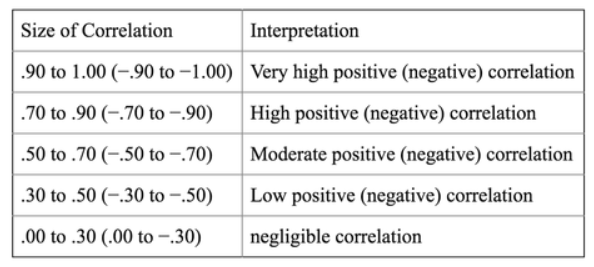

In [ ]:
sns.pairplot(df_USA, corner=True);

In [ ]:
df_USA =df_USA.set_index('year')

fig, ax = plt.subplots(figsize=(12,6))
df_USA['population'].plot(ax=ax,color='b',label='Population',kind='line')
plt.legend(bbox_to_anchor=(0.0, 0.90), loc=2, borderaxespad=0.)

ax2 = ax.twinx()
df_USA.gdp_for_capita.plot(ax=ax2,color='r',label='gdp_for_capita', marker='o')
plt.legend(bbox_to_anchor=(0.0, 0.80), loc=2, borderaxespad=0.)
ax.grid()

As the population has increased in the USA over the years, the national income per capita has also increased.

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
df_USA['suicides_100k'].plot(ax=ax,color='b',label='suicides_100k',kind='line')
plt.legend(bbox_to_anchor=(0.0, 0.90), loc=2, borderaxespad=0.)

ax2 = ax.twinx()
df_USA.gdp_for_capita.plot(ax=ax2,color='r',label='gdp_for_capita', marker='o')
plt.legend(bbox_to_anchor=(0.0, 0.80), loc=2, borderaxespad=0.)
ax.grid()

While the suicide rate in the USA had a high negative correlation with national income until 2000, it had a high positive correlation after 2000. The year 2000 has been the breaking point.

**Features Correlation of All**

In [ ]:
df_all_world = pd.pivot_table(df,values= ['suicides_no','population'], 
               index=['year'], aggfunc='sum').reset_index()
df_all_world['suicides_100k']=df_all_world['suicides_no']/df_all_world['population']*100000
df_all_world['gdp_for_year']=df.groupby('year').gdp_for_year.mean().values
df_all_world['gdp_for_capita'] = df_all_world['gdp_for_year'] / df_all_world['population']
# df_all_world

In [ ]:
plt.subplots(figsize=(8,6))
sns.heatmap(df_all_world[df_all_world.year!=2016].corr(), annot = True);

In [ ]:
sns.pairplot(df_all_world,corner=True);

In [ ]:
df_all_world =df_all_world[df_all_world.year!=2016].set_index('year')

fig, ax = plt.subplots(figsize=(12,6))
df_all_world['population'].plot(ax=ax,color='b',label='Population',kind='line')
plt.legend(bbox_to_anchor=(0.0, 0.90), loc=2, borderaxespad=0.)

ax2 = ax.twinx()
df_all_world.gdp_for_capita.plot(ax=ax2,color='r',label='gdp_for_capita', marker='o')
plt.legend(bbox_to_anchor=(0.0, 0.80), loc=2, borderaxespad=0.)
ax.grid()

- Since 2016 data is too incomplete, it is not included in the image as it may provide incorrect insight.
- While the world's per capita income was fluctuating until the beginning of the 2000s, it tended to increase after this date, except for the 2007 financial crisis.
- Although the population always tends to increase according to the graph, there has been a tendency to decrease after 2010. It should be taken into account that this may be due to the lack of dataset.

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
df_all_world['suicides_100k'].plot(ax=ax,color='b',label='suicides_100k',kind='line')
plt.legend(bbox_to_anchor=(0.0, 0.90), loc=2, borderaxespad=0.)

ax2 = ax.twinx()
df_all_world.gdp_for_capita.plot(ax=ax2,color='r',label='gdp_for_capita', marker='o')
plt.legend(bbox_to_anchor=(0.0, 0.80), loc=2, borderaxespad=0.)
ax.grid()

- Since 2016 data is too incomplete, it is not included in the image as it may provide incorrect insight.
- While suicide rates tended to increase all over the world until 1995, they tended to decrease sharply after 1995.
- While the world's per capita income was fluctuating until the beginning of the 2000s, it tended to increase after this date, except for the 2007 financial crisis.


### Data Visualization in Detail

**Suicide Counts by Gender**

In [ ]:
def func(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n( {:.2f}M )".format(pct,round(absolute/1000000,2))

suicide_counts_by_sex = df.groupby('sex').suicides_no.sum()

fig, ax = plt.subplots(figsize=(7,7))
ax.pie(x = suicide_counts_by_sex.values[::-1], 
        labels=suicide_counts_by_sex.index[::-1], 
       explode=(0, 0.1),
       autopct=lambda pct: func(pct, suicide_counts_by_sex.values[::-1]),
       startangle=90)
ax.set_title("Suicide Counts by Gender");
plt.show()

The total number of women who commit suicide is about 1/3 of the men who commit suicide

**Suicide Rates by Regions**

In [ ]:
plt.subplots(figsize=(15,6))
df.groupby('region').suicides_100k.mean().sort_values(ascending=False).plot.bar(rot=0)
plt.title("Suicide Rates by Regions");

European society more prone to suicide

In [ ]:
def labels(ax, df=df):
    for p in ax.patches:
            ax.annotate('{:.1f}'.format(p.get_height()), 
                        (p.get_x()+0.12, p.get_height()+0.3), size=8)

plt.subplots(figsize=(15,6))
df_reg = pd.DataFrame(df.groupby(['region','sex']).suicides_100k.mean().sort_values(ascending=False)).reset_index()
ax = sns.barplot(x='region',y='suicides_100k',data=df_reg, hue='sex')
plt.title("Suicide Rates by Regions & Gender")
labels(ax,df_reg)

While we find that men are more suicidal in male-female suicide, this difference is relatively small in Asia.

**Suicide Rates by Sub-Regions**

In [ ]:
plt.subplots(figsize=(15,6))
df.groupby('sub_region').suicides_100k.mean().sort_values(ascending=False).plot.bar(rot=90)
plt.title("Suicide Rates by Sub-Regions");

On a Sub-Region basis, East Asia has higher suicide rates than Europe, as it has the highest suicide rate in the world.

In [ ]:
def labels(ax, df=df):
    for p in ax.patches:
            ax.annotate('{:.1f}'.format(p.get_height()), 
                        (p.get_x()+0.12, p.get_height()+0.3), size=8)

fig,ax = plt.subplots(figsize=(20,6))
df_subreg = pd.DataFrame(df.groupby(['sub_region','sex']).suicides_100k.mean().sort_values(ascending=False)).reset_index()
ax = sns.barplot(x='sub_region',y='suicides_100k',data=df_subreg, hue='sex')
ax.set_title("Suicide Rates by Sub Regions & Gender")
ax.set_xticklabels(df_subreg.sub_region.unique(),rotation=90)
labels(ax,df_subreg)

Looking at the previous chart in gender detail, it is seen that there are female suicide rates in East Asia that are above the world average.

**Average Suicide Rates by Country from 1985 to 2016**

In [ ]:
df_cavg = pd.pivot_table(df,values= ['suicides_100k'], 
               index=['country' ]).sort_values(by=['suicides_100k'],ascending=False)


fig, ax = plt.subplots(figsize=(25,10))
sns.barplot(x=df_cavg.index, y='suicides_100k', data=df_cavg)
ax.set_title("Average Suicide Rates by Country from 1985 to 2016")
ax.axhline(y=df_cavg.mean()[0], color="blue", ls="--",label=f'avg_suicide_rate_by_country:{round(df_cavg.mean()[0],2)}')
ax.set_xticklabels(df_cavg.index, rotation=90)
ax.legend();

Looking at the average suicide rates for the years 1985-2016 by country, Lithuania is the country with the highest suicide rate.

**Suicide Counts by Country in 2015**

In [ ]:
df_cys = pd.pivot_table(df,values= ['suicides_no'], 
               index=['country', 'year', ], aggfunc='sum').reset_index()


fig, ax = plt.subplots(figsize=(25,12))
sns.barplot(y='country', x='suicides_no', data=df_cys[df_cys.year==2015].sort_values(by='suicides_no', ascending=False))
ax.set_title("Suicide Counts by Country in 2015")
ax.axvline(x=df_cys.mean()[0], color="blue", ls="--",label=f'avg_suicide_rate_by_country:{round(df_cys.mean()[0],2)}')
ax.legend();

Since the 2016 data are missing, the 2015 data with full data was focused on. Considering the total number of suicides, the highest number of suicides occurred in the USA-Russia-Japan order. However, this can be misleading. Because these countries are countries with large populations, we cannot say, for example, that USA is the country with the highest suicidal tendency. We have to look at the suicide rate in 100,000.

**Suicide Rates by Country in 2015**

In [ ]:
df_cysr = pd.pivot_table(df,values= ['suicides_100k'], 
               index=['country', 'year', ], aggfunc='mean').reset_index()


fig, ax = plt.subplots(figsize=(25,12))
sns.barplot(y='country', x='suicides_100k', data=df_cysr[df_cysr.year==2015].sort_values(by='suicides_100k', ascending=False))
ax.set_title("Suicide Rates by Country in 2015")
ax.axvline(x=df_cysr.suicides_100k.mean(), color="blue", ls="--",label=f'avg_suicide_rate_by_country:{round(df_cysr.suicides_100k.mean(),2)}')
ax.legend();
plt.show()

According to 2015 data, the Republic of Korea and Lithuania are by far the countries with the highest suicide rates in the world.

**suicides_100k rates by Generations**

In [ ]:
df_gs = pd.pivot_table(df,values= ['suicides_100k'], 
               index=['generation', 'sex', ])


def labels(ax, df=df):
    for p in ax.patches:
            ax.annotate('{:.1f}'.format(p.get_height()), 
                        (p.get_x()+0.12, p.get_height()+0.3), size=8)


fig, ax = plt.subplots(figsize=(15,6))
ax = sns.barplot(x='generation', y='suicides_100k',hue='sex',
                 data=df_gs.sort_values(by=['suicides_100k'], ascending=False).reset_index())
labels(ax,df_gs.suicides_100k)

While `G.I. Generation` born between 1910 and 1924 has the highest suicide rate, this rate gradually decreases in later generations.

In [ ]:
df_g = pd.pivot_table(df,values= ['suicides_100k'], index=['generation' ],aggfunc='mean')
df_s = pd.pivot_table(df,values= ['suicides_no'], index=['generation' ],aggfunc='sum')
df_s = df_s.merge(df_g,on='generation').sort_values(by=['suicides_no'],ascending=False)

def label(ax, df=df):
    for p in ax.patches:
            ax.annotate('{:.1f}'.format(p.get_height()), 
                        (p.get_x()+0.25, p.get_height()+0.2),size=10)

fig,ax=plt.subplots(1,2,figsize=(18,8))
df_s['suicides_no'].plot.pie(explode=[0.1,0.1,0.1,0.1,0.1,0.1],labels= df_s.index,ax=ax[0],shadow=True,
                            autopct=lambda pct: func(pct, df_s['suicides_no']))
# Alternative
# ax[0].pie(x = df_s['suicides_no'], 
#         labels = df_s.index, 
#        explode=[0.1,0.1,0.1,0.1,0.1,0.1],
#        autopct=lambda pct: func(pct, df_s['suicides_no']),
#        startangle=160)

ax[0].set_title('Generations Count')
ax[0].set_ylabel('')

sns.barplot(x=df_s.sort_values(by=['suicides_100k'],ascending=False).index,y='suicides_100k',
            data=df_s.sort_values(by=['suicides_100k'],ascending=False), ax=ax[1]);
ax[1].set_title('suicides_100k rates by Generations')
label(ax[1])
plt.show()

- The pie chart shows the generational distribution of the total number of suicides between 1985 and 2016. Boomers (born 1946-1964) are the generation with the highest number of suicides
- The bar graph shows the suicide rate among the generations between 1985 and 2016. Here G.I. Generation(born between 1910-1924) has the highest suicide rate. When we multiply the suicide numbers on the pie chart into their populations, we get the suicide rates on the bar graph.

**Suicide Rates by Age Group**

In [ ]:
fig,ax=plt.subplots(figsize=(15,5))
df.groupby('age').suicides_100k.mean().sort_values(ascending=False).plot.bar(rot=0, ax=ax)
ax.set_title("Suicide Rates by Age Group")
label(ax)

In [ ]:
df_as = pd.pivot_table(df,values= ['suicides_100k'], 
               index=['age', 'sex', ])


fig, ax = plt.subplots(figsize=(15,6))
ax = sns.barplot(x='age', y='suicides_100k',hue='sex',
                 data=df_as.sort_values(by=['suicides_100k'], ascending=False).reset_index())
labels(ax,df_gs.suicides_100k)

In [ ]:
df_a = pd.pivot_table(df,values= ['suicides_100k'], index=['age' ])
df_sa = pd.pivot_table(df,values= ['suicides_no'], index=['age' ],aggfunc='sum')
df_sa = pd.concat([df_a, df_sa], axis=1).sort_values(by=['suicides_no'],ascending=False)
df_sa

Suicide rate increases with age

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(18,8))
df_sa['suicides_no'].plot.pie(explode=[0.1,0.1,0.1,0.1,0.1,0.1],labels= df_sa.index,ax=ax[0],shadow=True,
                              autopct=lambda pct: func(pct, df_s['suicides_no']))
ax[0].set_title('Age Group Count')
ax[0].set_ylabel('')

sns.barplot(x=df_sa.sort_values(by=['suicides_100k'],ascending=False).index,y='suicides_100k',data=df_sa.sort_values(by=['suicides_100k'],ascending=False), ax=ax[1]);
ax[1].set_title('suicides_100k rates by Age Group')
label(ax[1])
plt.show()

- The pie chart shows the distribution of the total number of suicides between 1985 and 2016 by age group. The generation aged 35-54 with the highest number of suicides
- The bar graph shows the suicide rate among the age groups between 1985 and 2016. Here, over 75 years old has the 'highest suicide rate'. When we multiply the suicide numbers on the pie chart into their populations, we get the suicide rates on the bar graph.

**Suicide Rates by Years**

In [ ]:
avg_suicide_rate_by_year= df.groupby('year').suicides_no.sum() / df.groupby('year').population.sum()*100000

fig, ax = plt.subplots(figsize=(15,5))
df.groupby('year').suicides_100k.mean().plot.bar(ax=ax)
ax.set_title("Suicide Rates by Years")
ax.axhline(y=avg_suicide_rate_by_year.mean(), color="red", ls="--",
           label=f'avg_suicide_rate_by_year:{round(avg_suicide_rate_by_year.mean(),2)}')
ax.legend();

In [ ]:
df1 = df.groupby(['year','sex']).suicides_100k.mean()
df1 = pd.DataFrame(df1).reset_index()

sns.lmplot(x="year", y="suicides_100k", hue="sex",
               truncate=True, height=5, aspect=2, data=df1, ci=None);

Over the years, suicide rates tended to increase for men up to 1995 and then tended to fall, while for women they tended to decline in general.

In [ ]:
df2 = pd.pivot_table(df,values= ['suicides_100k','population','gdp_per_capita'], 
                     index=['country','sex','age','year' ]).sort_index(level=[2],ascending=False)


plt.figure(figsize=(20,5))
sns.lineplot(x="year", y="suicides_100k",hue="sex",data=df2);

In [ ]:
plt.figure(figsize=(15,5))
sns.kdeplot(x='suicides_100k',data=df2.reset_index(), hue='sex', shade=True)
plt.xlim([-10,50]);

While the standard deviation is low in female suicide data, it is higher in males.

**Suicide Counts by Years**

In [ ]:
df_ss = pd.pivot_table(df,values= ['suicides_no'], 
                     index=['sex','year'], aggfunc='sum').reset_index()
fig, ax = plt.subplots(figsize=(20,5))
for i in ['male','female']:
    ax = df_ss[df_ss.sex==i].groupby('year').suicides_no.sum().plot(kind='line',label=i)
ax.legend(loc='upper right', borderaxespad=0.5)
ax.set_ylabel('suicides_no')
ax.set_title('Suicide Count by Age Group in Years')
plt.show()

Since there is missing data in 2016, after 2015 should not be taken into account in this chart.

**GDP per Capita by Country in Descending Order**

In [ ]:
df_gp = pd.pivot_table(df,values= ['population','gdp_per_capita'], 
                     index=['country'], aggfunc='max').sort_values(by=['gdp_per_capita'],ascending=False)


fig, ax = plt.subplots(figsize=(25,8))
df_gp.gdp_per_capita.plot.bar(ax=ax)
ax.set_title("GDP per Capita by Country in Descending Order")
ax.axhline(y=df_gp.gdp_per_capita.mean(), color="red", ls="--",
           label=f'avg_gdp_per_capita:{round(df_gp.gdp_per_capita.mean(),2)}')
ax.set_ylabel('GDP')
ax.legend();

The countries with the highest per capita income are Luxembourg, Norway and Qatar, respectively.

**Suicide Rate in Top 5 countries by GDP in Years**

In [ ]:
df_yc = pd.pivot_table(df,values= ['suicides_100k','gdp_per_capita'], 
                     index=['country','year']).reset_index()

df_yc['gdp_per_capita_max']=df_yc.groupby('country').gdp_per_capita.transform(max)
country_order_gdp = df_yc[['country','gdp_per_capita_max']].drop_duplicates().sort_values(by=['gdp_per_capita_max'],ascending=False)['country'].values
# country_order_gdp

In [ ]:
fig, ax = plt.subplots(figsize=(20,12))
for i in country_order_gdp[:5]:
    ax = df_yc[df_yc.country==i].groupby('year').suicides_100k.mean().plot(kind='line',label=i)
ax.legend(loc='upper right', borderaxespad=0.5)
ax.set_title('Suicide Rate in Top 5 countries by GDP in Years')
ax.set_ylabel('suicides_100k')
plt.show()

You can see that the suicide rates of the 5 countries with the highest GDP change over time, with the exception of Qatar, the overall suicide rate tends to decrease.

**Suicide Rate by Generations in Years**

In [ ]:
df_sayg = pd.pivot_table(df,values= ['suicides_100k','gdp_per_capita'], 
                     index=['sex','age','year','generation']).reset_index()


fig, ax = plt.subplots(figsize=(20,8))
for i in ['G.I. Generation', 'Silent','Boomers','Generation X', 'Millenials','Generation Z']:
    ax = df_sayg[df_sayg.generation==i].groupby('year').suicides_100k.mean().plot(kind='line',label=i)
ax.legend(loc='upper right', borderaxespad=0.5)
ax.set_ylabel('suicides_100k')
ax.set_title('Suicide Rate by Generations in Years')
plt.show()

Let's visualize the Suicide Rate by Generation over the Years in gender detail

In [ ]:
df_sayg = pd.pivot_table(df,values= ['suicides_100k'], 
                     index=['sex','age','year','generation']).sort_index(level=3, ascending=False).reset_index()

fig, ax = plt.subplots(figsize=(20,15))
fig.suptitle("Suicide Rate for Generations by Gender in Years", fontsize=20).set_y(0.9)
fig.subplots_adjust(top=0.85)
for i,v in enumerate(['G.I. Generation', 'Silent','Boomers','Generation X', 'Millenials','Generation Z']):
    plt.subplot(3,2,i+1)
    sns.lineplot(x='year', y='suicides_100k', hue='sex',data=df_sayg[df_sayg.generation==v], ci=None)
    plt.title(v)
plt.show()

While the gap in the suicide rates of generations on a male-female basis generally tends to increase over the years, there is a tendency to decrease dramatically in generation Z since 2013.

**Suicide Rate by Age Group in Years**

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
for i in ['75+ years', '55-74 years','35-54 years','25-34 years','15-24 years', '05-14 years']:
    ax = df_sayg[df_sayg.age==i].groupby('year').suicides_100k.mean().plot(kind='line',label=i)
ax.legend(loc='upper right', borderaxespad=0.5)
ax.set_ylabel('suicides_100k')
ax.set_title('Suicide Rate by Age Group in Years')
plt.show()

While suicide rates of age groups peaked in 1995, they generally continued to decline in the following years.

**Suicide Count by Age Group in Years**

In [ ]:
df_sayg_no = pd.pivot_table(df,values= ['suicides_no'], 
                     index=['sex','age','year','generation'], aggfunc='sum').sort_index(level=3, ascending=False).reset_index()


fig, ax = plt.subplots(figsize=(20,8))
for i in ['75+ years', '55-74 years','35-54 years','25-34 years','15-24 years', '05-14 years']:
    ax = df_sayg_no[df_sayg_no.age==i].groupby('year').suicides_no.mean().plot(kind='line',label=i)
ax.legend(loc='upper right', borderaxespad=0.5)
ax.set_ylabel('suicides_no')
ax.set_title('Suicide Count by Age Group in Years')
plt.show()

When we look at the suicide numbers of the age groups, the highest rate of suicide is between the ages of 35-54, but the rate is lower because the population of this group is high. Since the data for 2016 is incomplete, that year should not be taken into account.

**Suicide Count by Age Group and Gender in Years**

In [ ]:
fig, ax = plt.subplots(figsize=(20,15))
fig.suptitle("Suicide Count by Age Group and Gender in Years", fontsize=20).set_y(0.9)
fig.subplots_adjust(top=0.85)
for i,v in enumerate(['75+ years', '55-74 years','35-54 years','25-34 years','15-24 years', '05-14 years']):
    plt.subplot(3,2,i+1)
    sns.lineplot(x='year', y='suicides_no', hue='sex',data=df_sayg_no[df_sayg_no.age==v])
    plt.title(v)
plt.show()

The gap between male and female suicides in 5-14 year-old suicides has tended to decrease since the 2000s.

**GDP per Capita of G8 Countries in Years**

In [ ]:
df_cy = pd.pivot_table(df,values= ['population','gdp_per_capita', 'suicides_100k'], 
                     index=['country','year']).reset_index()


g8 = ['Canada','France','Germany','Italy','Japan','United Kingdom','United States','Russian Federation']

fig, ax = plt.subplots(figsize=(20,8))
for i in g8:
    ax = df_cy[df_cy.country==i].groupby('year').gdp_per_capita.mean().plot(kind='line',label=i)
ax.legend(loc='upper left', borderaxespad=0.5)
ax.set_ylabel('suicides_100k')
ax.set_title('GDP per Capita of G8 Countries in Years')
plt.show()

We see the change in the GDPs of the G8 countries over the years, although there was a decrease in the GDP in the 2001 and 2007 crises, the GDPs tend to increase in general.

**Suicide Rates of G8 Countries in Years**

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
for i in g8:
    ax = df_cy[df_cy.country==i].groupby('year').suicides_100k.mean().plot(kind='line',label=i)
ax.legend(loc='upper left', borderaxespad=0.5)
ax.set_ylabel('suicides_100k')
ax.set_title('Suicide Rates of G8 Countries in Years')
plt.show()

It is observed that the suicide rates of G8 countries also tend to decrease over the years. Suicide rates in Russia seem to have increased dramatically after the collapse of the Soviet Union.

**Distribution of GDP, Population & Suicide Rate by Region**

In [ ]:
df_cpgs = pd.pivot_table(df,values= ['population','gdp_per_capita', 'gdp_for_year','suicides_100k'], 
                     index=['region','country'],aggfunc='max').reset_index()

for j in df_cpgs.region.unique():
    plt.figure(figsize=(25,7))
    plt.suptitle(j, fontsize=20)
    for i,v in enumerate(df_cpgs.columns[2:]):  
        plt.subplot(1,4,i+1)
        sns.boxplot(y =v, data=df_cpgs[df_cpgs.region==j])
    plt.tight_layout
    plt.show()


- As there are only 4 countries from Africa in the dataset (insufficient number of samples), the current dataset does not provide insight into the entire African continent

**Suicidal Intensity Map by Suicides Rates in 100k**
- pip install pycountry --user
- pip install plotly-express --user
- pip install plotly --user
- pip install pyclustertend --user

In [ ]:
# list_countries=df.country.unique()

# import pycountry
# d_country_code = {}  # To hold the country names and their ISO
# for country in list_countries:
#     try:
#         country_data = pycountry.countries.search_fuzzy(country)
#         # country_data is a list of objects of class pycountry.db.Country
#         # The first item  ie at index 0 of list is best fit
#         # object of class Country have an alpha_3 attribute
#         country_code = country_data[0].alpha_3
#         d_country_code.update({country: country_code})
#     except:
#         print('could not add ISO 3 code for ->', country)
#         # If could not find country, make ISO code ' '
#         d_country_code.update({country: ' '})

In [ ]:
df_map = pd.pivot_table(df,values= ['suicides_100k'], 
                     index=['region','country','alpha_3'],aggfunc='mean').reset_index()

import plotly.express as px

fig = px.choropleth(data_frame = df_map,
                    locations= "alpha_3",
                    color= "suicides_100k",
                    hover_name= "country",
                    color_continuous_scale= 'thermal',
                   )

fig.show()

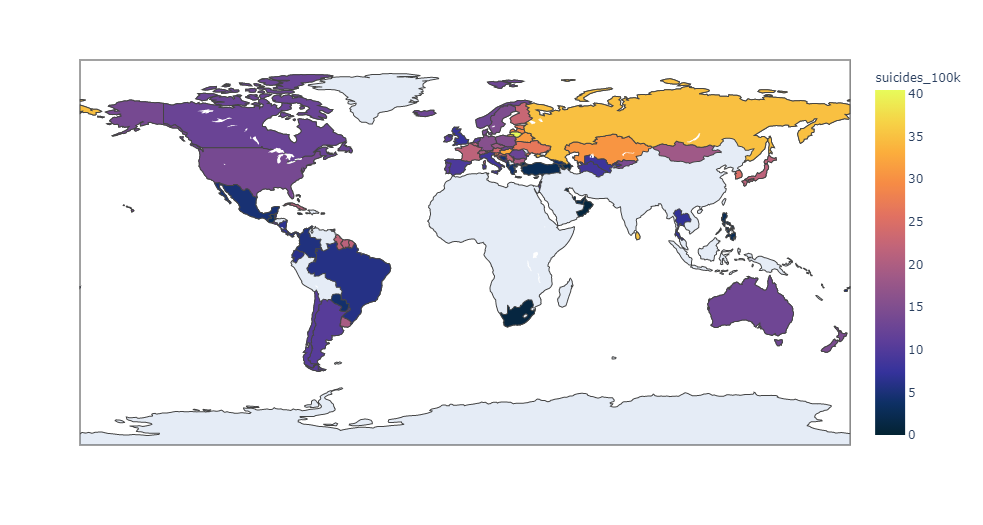